Folder 'layers/' has been emptied.


shift signal finished
fusion connected qubits validation success!


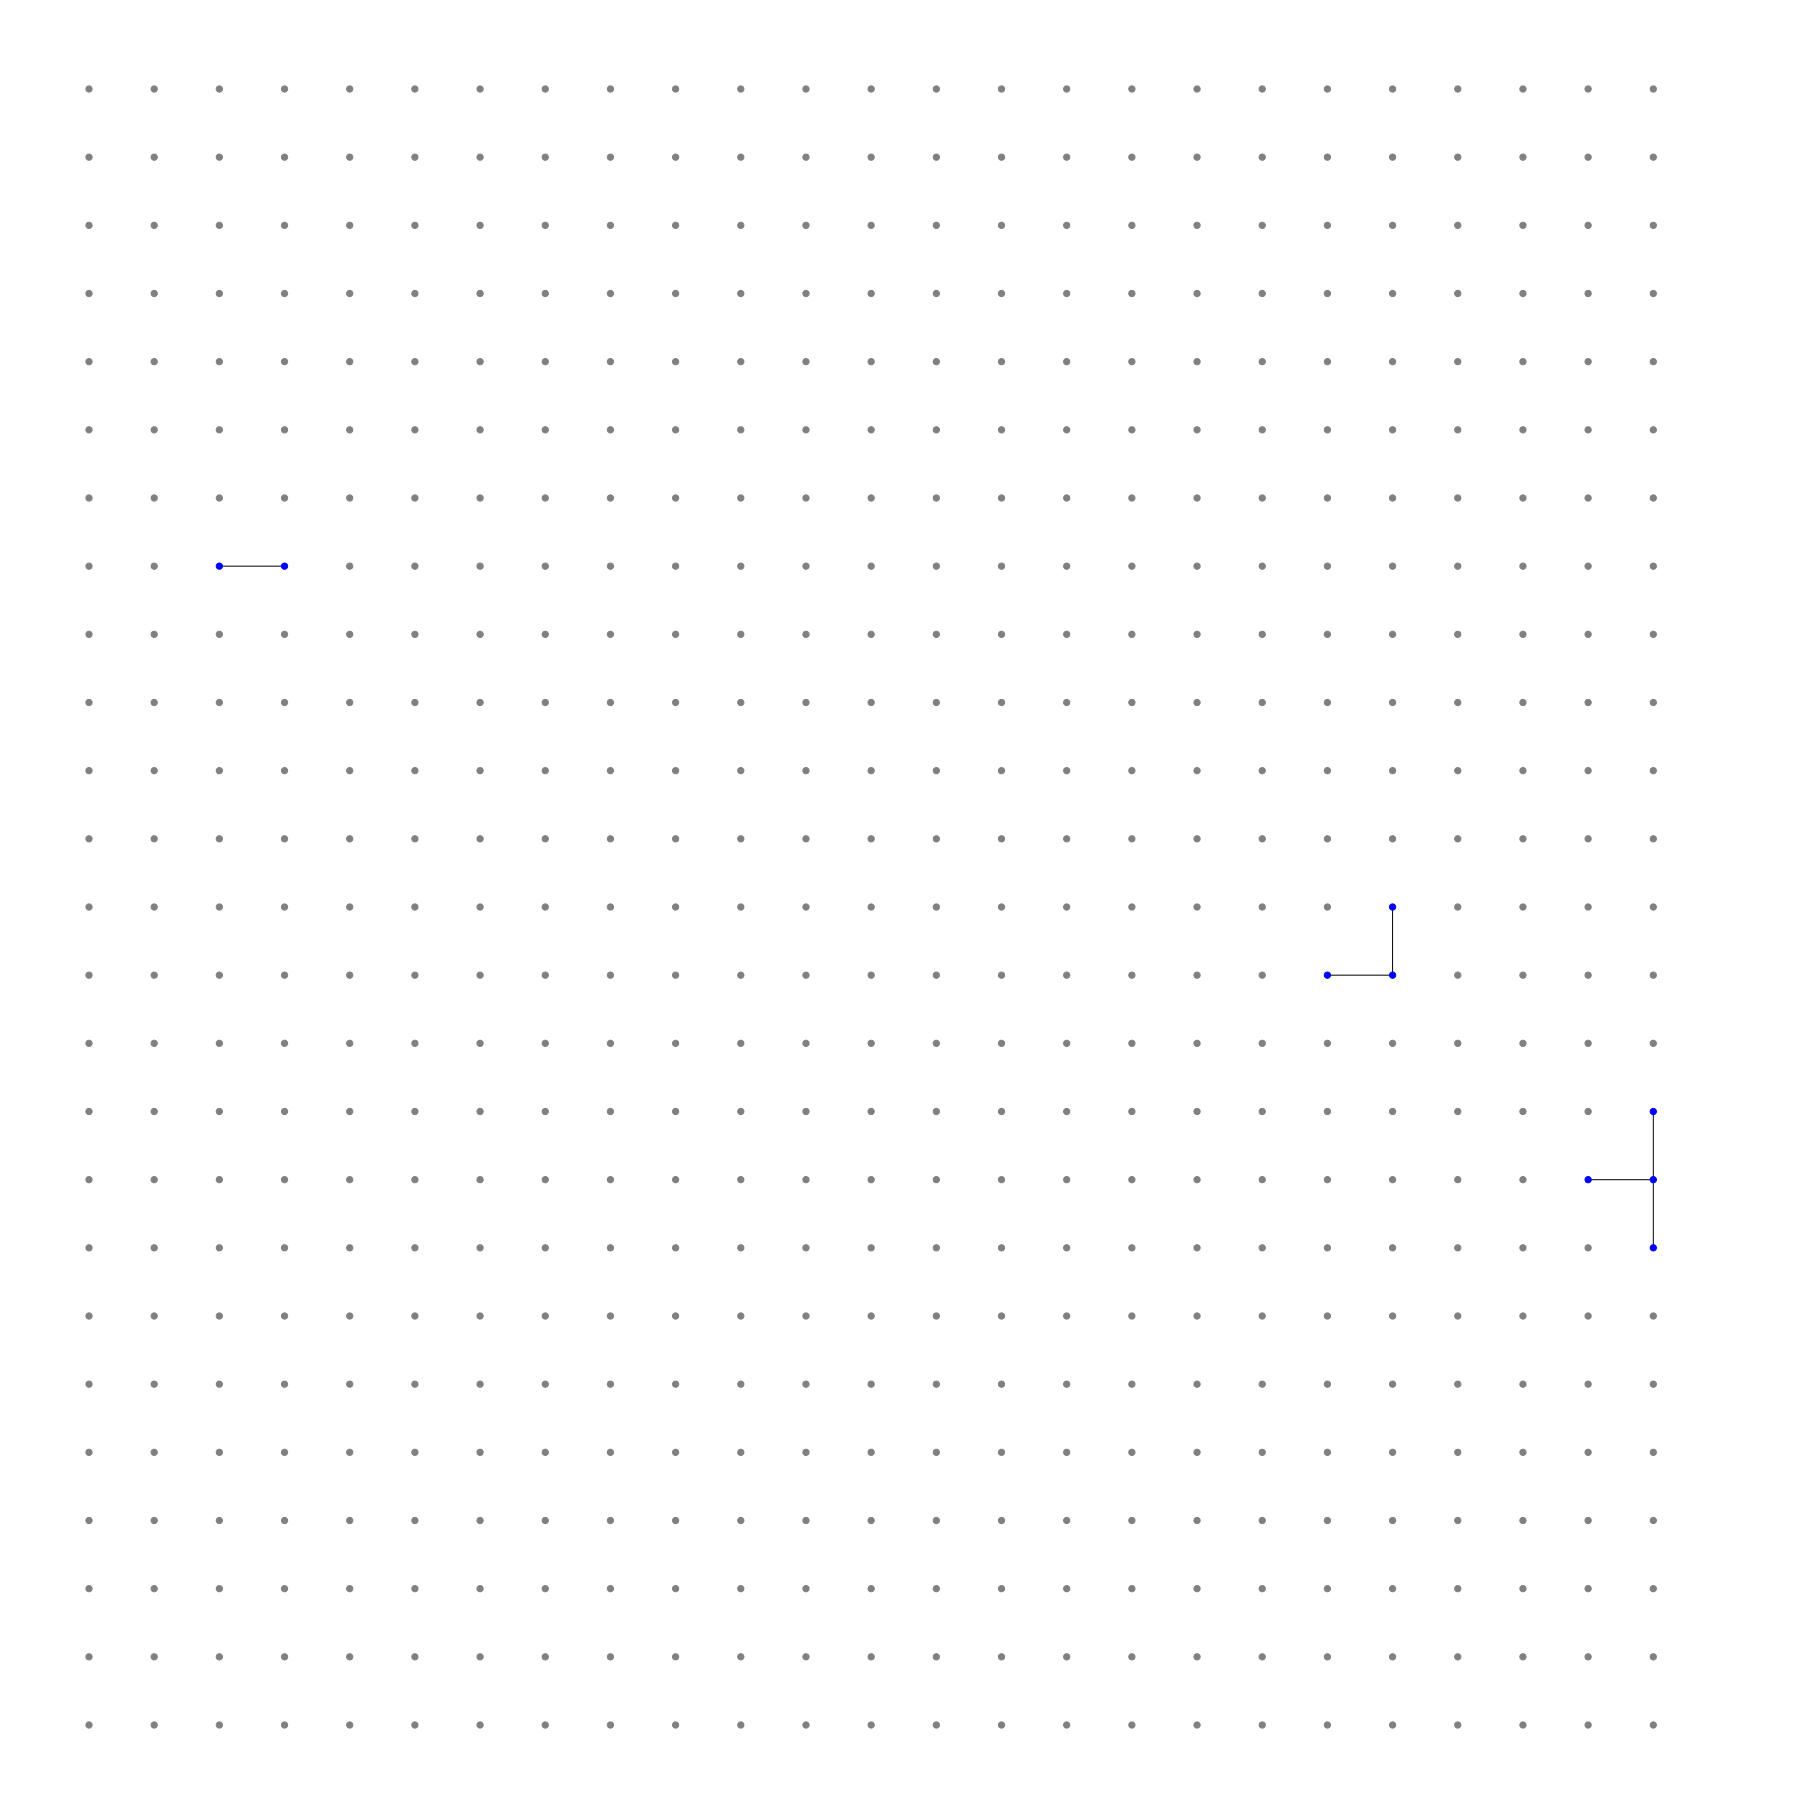

0
9 nodes
1 layers
fusion: 6
connect qubits validation success!


In [30]:
from Fusion import *
from Graph_State import *
from Compact_Graph_Dynamic import *
from Compact_Graph_Dynamic_List import *
from Compact_Graph_Dynamic_General import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Determine_Dependency import *
from Partition import *
from Add_Round import *
from Z_Measure_Notify import *
from Generate_State import *

import sys
import os

NQubit = 4
Depth = 10
MaxDegree = 16
StarStructure = False
DynamicSchedule = True
SpecialFusion = True
GeneralState = True

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        if StarStructure or MaxDegree <= 4:
            undirected_graph.nodes[nnode]['phase'] = gs.nodes[nnode]['phase']
        else:
            if not GeneralState:
                undirected_graph.nodes[nnode]['phase'] = []
                undirected_graph.nodes[nnode]['phase'].append(gs.nodes[nnode]['phase'])
            else:
                undirected_graph.nodes[nnode]['phase'] = {}
                undirected_graph.nodes[nnode]['phase'][0] = []
                undirected_graph.nodes[nnode]['phase'][0].append(gs.nodes[nnode]['phase'])                
        # if not Generalized_Flow_Flag:
        if not DynamicSchedule:
            undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']

    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
            undirected_graph[edge[0]][edge[1]]['con_qubits'] = {}
        if GeneralState:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 1
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 1    
            # print("general state")
        else:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 0
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 0                       
    return undirected_graph

def empty_folder(folder_path):
    if os.path.exists(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                empty_folder(item_path)
        print(f"Folder '{folder_path}' has been emptied.")
    else:
        print(f"Folder '{folder_path}' does not exist.")



def custom_main(gates_list, qubits):
    empty_folder("layers/")

    # generate graph state
    gs, input_nodes, colors = generate_graph_state(gates_list, qubits)
    
    if DynamicSchedule:
        # causal flow
        dgraph = determine_dependency(gs)
        # gs = schedule(gs, dgraph)
        # gs = partition(gs, input_nodes)
        # pos = nx.get_node_attributes(gs, 'pos')
        undirected_graph = to_undirected(gs)

        # # generalized flow
        # if Generalized_Flow_Flag:
        #     undirected_graph = generalized_flow(undirected_graph, input_nodes)
        #     labels = {node: str(undirected_graph.nodes[node]['layer']) for node in undirected_graph.nodes()}
        #     nx.draw(undirected_graph, pos = pos, labels = labels, node_size = 30, font_size = 10)


        # fusion
        if GeneralState:
            resource_state = generate_state(MaxDegree)
            fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())
            while fgraph == -1:
                resource_state = generate_state(MaxDegree)
                fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())                
        else:
            fgraph, added_nodes = fusion_graph_dynamic(undirected_graph, MaxDegree, StarStructure, SpecialFusion)
        
        # add rounds
        # fgraph = add_round(fgraph, 1)
        
        # map and route
        if GeneralState:
            net_list = compact_graph_dynamic_general(fgraph, dgraph.copy(), resource_state)
        elif StarStructure or MaxDegree <= 4:
            net_list = compact_graph_dynamic(fgraph, dgraph, MaxDegree)
        else:
            # if SpecialFusion:
            #     net_list = compact_graph_dynamic_list_special_fusion(fgraph, dgraph, MaxDegree)
            # else:
            net_list = compact_graph_dynamic_list(fgraph, dgraph, MaxDegree, SpecialFusion)
    else:
        gs = partition(gs, input_nodes)
        undirected_graph = to_undirected(gs)
        fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree, StarStructure)
        fgraph = add_round(fgraph, 1)
        net_list = compact_graph(fgraph, MaxDegree)
    
    if not GeneralState and not StarStructure:
        net_list = z_measure_notify(net_list, MaxDegree)
    # show result
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    
    if GeneralState:
        validate_con_qubits_list(net_list, MaxDegree) 
    elif StarStructure or MaxDegree <= 4:
        validate_con_qubits(net_list, MaxDegree)
        fgraph = validate(net_list, fgraph, MaxDegree) 
    else:
        validate_con_qubits_list(net_list, MaxDegree)  
    return

if __name__ == '__main__':
    nqubit = 4
    test_circuit = zx.Circuit(qubit_amount=nqubit)
    test_circuit.add_gate("HAD", 0)
    test_circuit.add_gate("T", 1)
    test_circuit.add_gate("CNOT", 2, 3)

    qubits = []
    for i in range(nqubit):
        qubits.append(i)
    jcz_circuit = JCZCircuit()
    jcz_circuit.qubits_init(qubits)
    for gate in test_circuit.gates:
        # print(gate)
        if gate.name == "HAD":
            jcz_circuit.add_H(int(str(gate)[4:-1]))
        elif gate.name == "CNOT":
            gate_split = str(gate).split(',')
            qubit1 = int(gate_split[0][5:])
            qubit2 = int(gate_split[1][0:-1])
            jcz_circuit.add_CNOT(qubit1, qubit2)
        elif gate.name == "T":
            jcz_circuit.add_T(int(str(gate)[2:-1]))

    """
    test_circuit.add_gate("ZPhase", 4, phase=0.75)
    jcz_circuit.add_J(4, phase=0.75)

    test_circuit.add_gate("X", 5)
    jcz_circuit.add_X(5)

    test_circuit.add_gate("Z", 6)
    jcz_circuit.add_Z(6)

    test_circuit.add_gate("S", 7)
    jcz_circuit.add_S(7)

    test_circuit.add_gate("RZ", 8, angle=2)
    jcz_circuit.add_Rz(8, phase=2)

    test_circuit.add_gate("CZ", 9,10)
    jcz_circuit.add_CZ(9,10)

    target_qubit = 11
    control_qubit = 12
    test_circuit.add_gate("H", target_qubit)
    test_circuit.add_gate("CNOT", control_qubit, target_qubit)
    test_circuit.add_gate("RZ", target_qubit, angle=2)
    test_circuit.add_gate("CNOT", control_qubit, target_qubit)
    test_circuit.add_gate("H", target_qubit)
    jcz_circuit.add_CRz(11,12,phase=2)
    """

    zx.draw(test_circuit)
    custom_main(jcz_circuit.gates, nqubit)
 